In [33]:
import torch
import argparse
from torch.nn import CrossEntropyLoss
from torch.optim import SGD

from avalanche.benchmarks.classic import SplitMNIST
from avalanche.models import SimpleMLP
from avalanche.training.plugins.early_stopping import EarlyStoppingPlugin
from avalanche.training.supervised import Naive
from avalanche.evaluation.metrics import (
    forgetting_metrics,
    accuracy_metrics,
    loss_metrics,
    timing_metrics,
    cpu_usage_metrics,
    confusion_matrix_metrics,
    disk_usage_metrics,
    CumulativeAccuracyPluginMetric,
    CumulativeForgettingPluginMetric,
    ExperienceMaxRAM,
    ExperienceMaxGPU
)
from avalanche.logging import InteractiveLogger, TextLogger
from avalanche.training.plugins import EvaluationPlugin, EarlyStoppingPlugin
from avalanche.checkpointing import maybe_load_checkpoint, save_checkpoint
import numpy as np
# import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay
import mlflow
# Device config
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [11]:
import mlflow
mlflow.set_tracking_uri("postgresql+psycopg2://user:password@db:5432/mlflow")
mlflow.set_experiment("continual-learning-experiment")

2024/07/09 02:41:39 INFO mlflow.store.db.utils: Creating initial MLflow database tables...
2024/07/09 02:41:39 INFO mlflow.store.db.utils: Updating database tables
INFO  [alembic.runtime.migration] Context impl PostgresqlImpl.
INFO  [alembic.runtime.migration] Will assume transactional DDL.
INFO  [alembic.runtime.migration] Running upgrade  -> 451aebb31d03, add metric step
INFO  [alembic.runtime.migration] Running upgrade 451aebb31d03 -> 90e64c465722, migrate user column to tags
INFO  [alembic.runtime.migration] Running upgrade 90e64c465722 -> 181f10493468, allow nulls for metric values
INFO  [alembic.runtime.migration] Running upgrade 181f10493468 -> df50e92ffc5e, Add Experiment Tags Table
INFO  [alembic.runtime.migration] Running upgrade df50e92ffc5e -> 7ac759974ad8, Update run tags with larger limit
INFO  [alembic.runtime.migration] Running upgrade 7ac759974ad8 -> 89d4b8295536, create latest metrics table
INFO  [89d4b8295536_create_latest_metrics_table_py] Migration complete!
INFO  

<Experiment: artifact_location='/home/jovyan/work/mlruns/1', creation_time=1720492900142, experiment_id='1', last_update_time=1720492900142, lifecycle_stage='active', name='continual-learning-experiment', tags={}>

In [12]:
model = SimpleMLP(num_classes=10)

benchmark = SplitMNIST(n_experiences=5, seed = 1, fixed_class_order=list(range(10)))

# Than we can extract the parallel train and test streams
train_stream = benchmark.train_stream
test_stream = benchmark.test_stream

# Prepare for training & testing
optimizer = SGD(model.parameters(), lr=0.001, momentum=0.9)
criterion = CrossEntropyLoss()


# Evaluation metric
interactive_logger = InteractiveLogger()

eval_plugin = EvaluationPlugin(
        accuracy_metrics(minibatch=False, epoch=False, experience=True, stream=True),
        loss_metrics(minibatch=False, epoch=False, experience=True, stream=True),
        timing_metrics(epoch=False, epoch_running=True),
        forgetting_metrics(experience=True, stream=True),
        cpu_usage_metrics(experience=True),
        confusion_matrix_metrics(
            num_classes=10, save_image=True, absolute_class_order= True, stream=True
        ),
        CumulativeAccuracyPluginMetric(),
        CumulativeForgettingPluginMetric(),
        ExperienceMaxGPU(gpu_id=0),
        ExperienceMaxRAM(),
        disk_usage_metrics(minibatch=False, epoch=False, experience=True, stream=True),
        loggers=[TextLogger(open('out.txt', 'w')), interactive_logger]
    )
BATCH_SIZE= 1024

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9912422/9912422 [00:00<00:00, 40895979.17it/s]


Extracting /home/jovyan/.avalanche/data/mnist/MNIST/raw/train-images-idx3-ubyte.gz to /home/jovyan/.avalanche/data/mnist/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28881/28881 [00:00<00:00, 11265292.83it/s]

Extracting /home/jovyan/.avalanche/data/mnist/MNIST/raw/train-labels-idx1-ubyte.gz to /home/jovyan/.avalanche/data/mnist/MNIST/raw



Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1648877/1648877 [00:00<00:00, 25470644.94it/s]


Extracting /home/jovyan/.avalanche/data/mnist/MNIST/raw/t10k-images-idx3-ubyte.gz to /home/jovyan/.avalanche/data/mnist/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4542/4542 [00:00<00:00, 3404920.24it/s]

Extracting /home/jovyan/.avalanche/data/mnist/MNIST/raw/t10k-labels-idx1-ubyte.gz to /home/jovyan/.avalanche/data/mnist/MNIST/raw




/opt/conda/lib/python3.11/site-packages/avalanche/evaluation/metrics/gpu_usage.py:56: UserWarning: Your system has no GPU!
  warnings.warn("Your system has no GPU!")


In [13]:
def reset_parameters(model):
    for layer in model.children():
        if hasattr(layer, 'reset_parameters'):
            layer.reset_parameters()

In [14]:
for id, experience in enumerate(train_stream):
  print(f"Task {experience.task_label}")
  print(f"Classes in this experience {experience.classes_in_this_experience}")
  dataset = experience.dataset
  print(f"Train data contains {len(dataset)} patterns. With benchmark {train_stream.benchmark}")
  # for x, y, t in dataset:
  #   pass

  test_experience = test_stream[id]
  cumulative_test = test_stream[:id+1]
  print(f"Test data contains {len(test_experience.dataset)}")

Task 0
Classes in this experience [0, 1]
Train data contains 12665 patterns. With benchmark <avalanche.benchmarks.scenarios.deprecated.new_classes.nc_scenario.NCScenario object at 0x749d90e93d10>
Test data contains 2115
Task 0
Classes in this experience [2, 3]
Train data contains 12089 patterns. With benchmark <avalanche.benchmarks.scenarios.deprecated.new_classes.nc_scenario.NCScenario object at 0x749d90e93d10>
Test data contains 2042
Task 0
Classes in this experience [4, 5]
Train data contains 11263 patterns. With benchmark <avalanche.benchmarks.scenarios.deprecated.new_classes.nc_scenario.NCScenario object at 0x749d90e93d10>
Test data contains 1874
Task 0
Classes in this experience [6, 7]
Train data contains 12183 patterns. With benchmark <avalanche.benchmarks.scenarios.deprecated.new_classes.nc_scenario.NCScenario object at 0x749d90e93d10>
Test data contains 1986
Task 0
Classes in this experience [8, 9]
Train data contains 11800 patterns. With benchmark <avalanche.benchmarks.scenar

## Naive model

In [6]:
# cl_strategy = Naive(
#     model,
#     optimizer,
#     criterion,
#     train_mb_size=BATCH_SIZE,
#     train_epochs=100,
#     eval_mb_size=BATCH_SIZE,
#     device=device,
#     eval_every=1,
#     evaluator = eval_plugin,
#     plugins=[EarlyStoppingPlugin(5, "test_stream")],
# )

# # train and test loop
# naive_results = []
# for train_task, test_task in zip(train_stream, test_stream):
#   print()
#   print()
#   print("Current Classes: ", train_task.classes_in_this_experience)
#   cl_strategy.train(train_task, eval_streams=[test_task])
#   naive_results.append(cl_strategy.eval(test_stream))

## GDUMB 

In [15]:
from avalanche.training.plugins import GDumbPlugin

# Prepare for training & testing
reset_parameters(model)

optimizer = SGD(model.parameters(), lr=0.001, momentum=0.9)
criterion = CrossEntropyLoss()


# Continual learning strategy with default logger
cl_strategy = Naive(
    model,
    optimizer,
    criterion,
    train_mb_size=BATCH_SIZE,
    train_epochs=100,
    eval_mb_size=BATCH_SIZE,
    device=device,
    eval_every=1,
    evaluator = eval_plugin,
    plugins=[EarlyStoppingPlugin(5, "test_stream"), GDumbPlugin(mem_size=500)],
)

# train and test loop
gdumb_results = []
# for train_task, test_task in zip(train_stream, test_stream):
#   print()
#   print()
#   print("Current Classes: ", train_task.classes_in_this_experience)
#   cl_strategy.train(train_task, eval_streams=[test_task])
#   gdumb_results.append(cl_strategy.eval(test_stream))

/opt/conda/lib/python3.11/site-packages/avalanche/training/templates/base.py:468: PositionalArgumentsDeprecatedWarning: Avalanche is transitioning to strategy constructors that accept named (keyword) arguments only. This is done to ensure that there is no confusion regarding the meaning of each argument (strategies can have many arguments). Your are passing 3 positional arguments to the Naive.__init__ method. Consider passing them as names arguments. The ability to pass positional arguments will be removed in the future.
  warnings.warn(error_str, category=PositionalArgumentsDeprecatedWarning)


-- >> Start of training phase << --
-- >> Start of eval phase << --
-- Starting eval on experience 0 (Task 0) from test stream --
100%|██████████| 3/3 [00:00<00:00, 10.86it/s]
> Eval on experience 0 (Task 0) from test stream ended.
	CPUUsage_Exp/eval_phase/test_stream/Task000/Exp000 = 101.7024
	DiskUsage_Exp/eval_phase/test_stream/Task000/Exp000 = 529.5332
	Loss_Exp/eval_phase/test_stream/Task000/Exp000 = 0.7404
	MaxGPU0Usage_Experience/eval_phase/test_stream/Task000/Exp000 = 0
	MaxRAMUsage_Experience/eval_phase/test_stream/Task000/Exp000 = 884.0234
	Top1_Acc_Exp/eval_phase/test_stream/Task000/Exp000 = 0.9972


/opt/conda/lib/python3.11/site-packages/avalanche/training/plugins/early_stopping.py:114: UserWarning: Metric Top1_Acc_Stream used by the EarlyStopping plugin is not computed yet. EarlyStopping will not be triggered.
  warnings.warn(


-- >> End of eval phase << --
	ConfusionMatrix_Stream/eval_phase/test_stream = <avalanche.evaluation.metric_results.AlternativeValues object at 0x749d860c6ed0>
	CumulativeAccuracy/eval_phase/test_stream/Exp000 = 0.9972
	CumulativeForgetting/eval_phase/test_stream/Exp000 = -0.2374
	DiskUsage_Stream/eval_phase/test_stream/Task000 = 529.5332
	Loss_Stream/eval_phase/test_stream/Task000 = 0.7404
	StreamForgetting/eval_phase/test_stream = 0.0000
	Top1_Acc_Stream/eval_phase/test_stream/Task000 = 0.9972
100%|██████████| 1/1 [00:00<00:00, 15.01it/s]
Epoch 0 ended.
	RunningTime_Epoch/train_phase/train_stream/Task000 = 0.0687
-- >> Start of eval phase << --
-- Starting eval on experience 0 (Task 0) from test stream --
100%|██████████| 3/3 [00:00<00:00,  3.30it/s]
> Eval on experience 0 (Task 0) from test stream ended.
	CPUUsage_Exp/eval_phase/test_stream/Task000/Exp000 = 98.0128
	DiskUsage_Exp/eval_phase/test_stream/Task000/Exp000 = 529.5332
	Loss_Exp/eval_phase/test_stream/Task000/Exp000 = 2.156

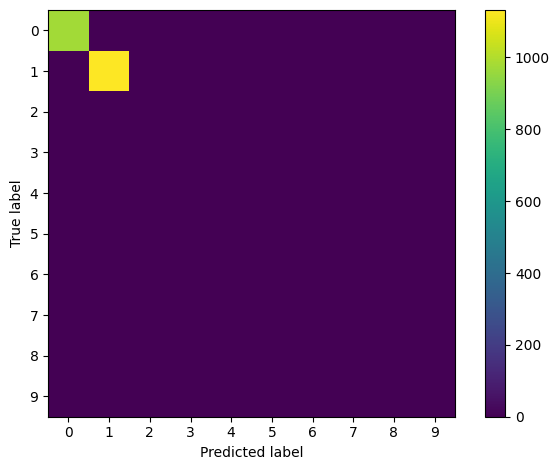

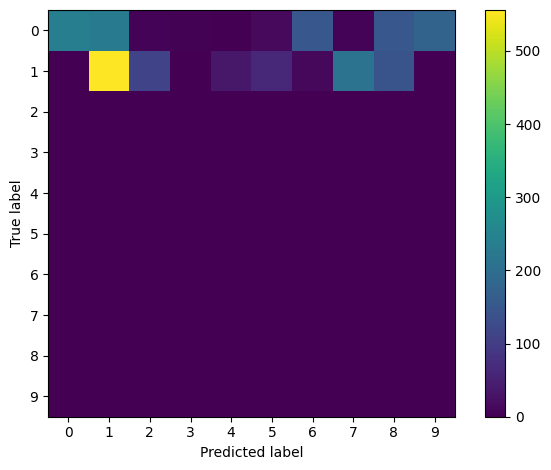

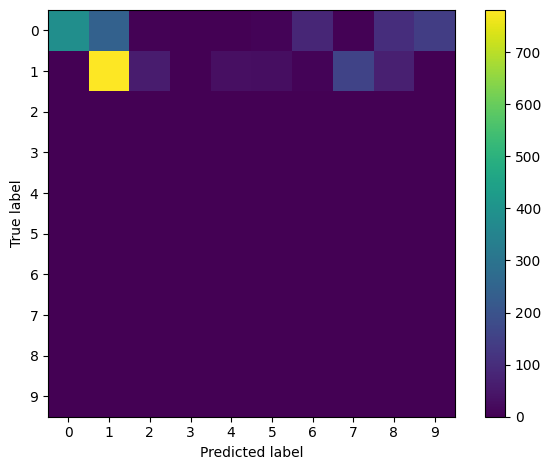

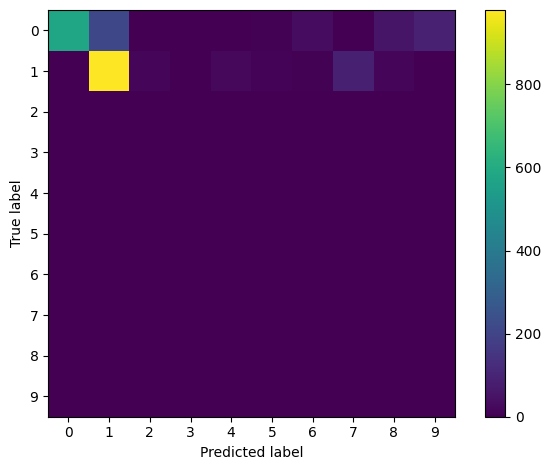

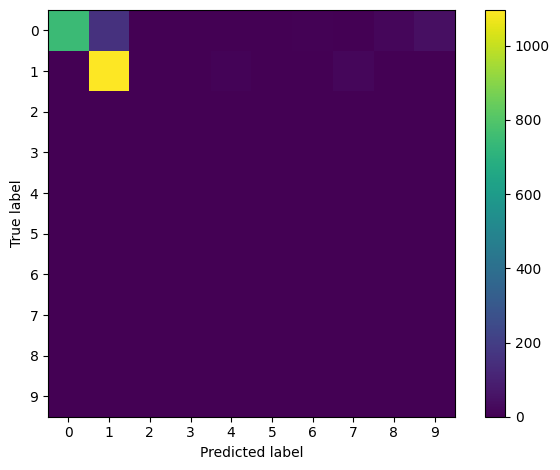

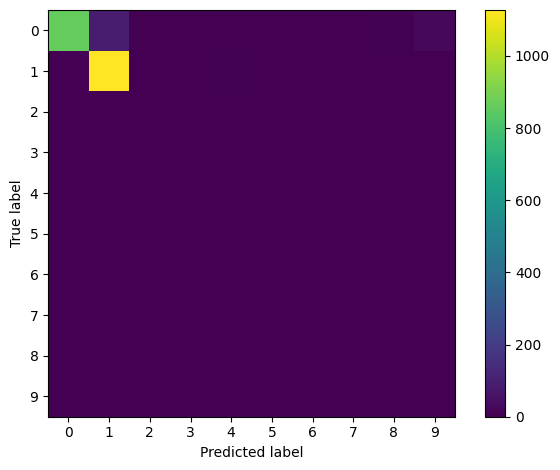

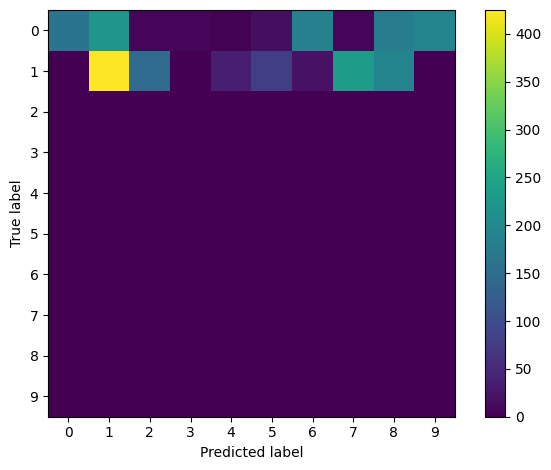

In [26]:
episode = 2
hist = cl_strategy.train(train_stream[0], eval_streams=[test_stream[0]])
eval = cl_strategy.eval(test_stream[0])

In [27]:
hist

{'Top1_Acc_Exp/eval_phase/test_stream/Task000/Exp000': 0.9394799054373523,
 'Loss_Exp/eval_phase/test_stream/Task000/Exp000': 1.678658240399462,
 'CPUUsage_Exp/eval_phase/test_stream/Task000/Exp000': 99.90771260414276,
 'MaxGPU0Usage_Experience/eval_phase/test_stream/Task000/Exp000': 0,
 'MaxRAMUsage_Experience/eval_phase/test_stream/Task000/Exp000': 0,
 'DiskUsage_Exp/eval_phase/test_stream/Task000/Exp000': 537.498046875,
 'Top1_Acc_Stream/eval_phase/test_stream/Task000': 0.9394799054373523,
 'Loss_Stream/eval_phase/test_stream/Task000': 1.678658240399462,
 'StreamForgetting/eval_phase/test_stream': 0.0,
 'ConfusionMatrix_Stream/eval_phase/test_stream': <avalanche.evaluation.metric_results.AlternativeValues at 0x749d85cac250>,
 'DiskUsage_Stream/eval_phase/test_stream/Task000': 537.498046875,
 'RunningTime_Epoch/train_phase/train_stream/Task000': 0.09747048700046435,
 'CumulativeAccuracy/eval_phase/test_stream/Exp000': 0.9508274231678487,
 'CumulativeForgetting/eval_phase/test_stream/

In [20]:
eval

{'Top1_Acc_Exp/eval_phase/test_stream/Task000/Exp000': 0.9971631205673759,
 'Loss_Exp/eval_phase/test_stream/Task000/Exp000': 0.7404264783464707,
 'CPUUsage_Exp/eval_phase/test_stream/Task000/Exp000': 96.84316823201439,
 'MaxGPU0Usage_Experience/eval_phase/test_stream/Task000/Exp000': 0,
 'MaxRAMUsage_Experience/eval_phase/test_stream/Task000/Exp000': 881.3984375,
 'DiskUsage_Exp/eval_phase/test_stream/Task000/Exp000': 124.6953125,
 'Top1_Acc_Stream/eval_phase/test_stream/Task000': 0.9971631205673759,
 'Loss_Stream/eval_phase/test_stream/Task000': 0.7404264783464707,
 'StreamForgetting/eval_phase/test_stream': 0.0,
 'ConfusionMatrix_Stream/eval_phase/test_stream': <avalanche.evaluation.metric_results.AlternativeValues at 0x749d86327a50>,
 'DiskUsage_Stream/eval_phase/test_stream/Task000': 124.6953125,
 'RunningTime_Epoch/train_phase/train_stream/Task000': 0.06773876799979917,
 'CumulativeAccuracy/eval_phase/test_stream/Exp000': 0.9971631205673759,
 'CumulativeForgetting/eval_phase/test

In [23]:
metric_map = {'Top1_Acc_Exp': 'Top1_Acc_Exp',
 'Loss_Exp': 'Loss_Exp',
 'CPUUsage_Exp': 'CPU_Usage',
 'MaxGPU0Usage_Experience': 'Max_GPU_Usage',
 'MaxRAMUsage_Experience': 'Max_RAM_Usage',
 'DiskUsage_Exp': 'Disk_Usage',
 'Top1_Acc_Stream': 'Top1_Acc_Stream',
 'Loss_Stream': 'Loss_Stream',
 'StreamForgetting': 'Stream_Forgetting',
 'DiskUsage_Stream': 'Disk_Usage_Stream',
 'RunningTime_Epoch': 'Running_Time',
 'CumulativeAccuracy': 'Cumulative_Accuracy',
 'CumulativeForgetting': 'Cumulative_Forgetting'}

{'train_Top1_Acc_Exp': 0.9394799054373523,
 'train_Loss_Exp': 1.678658240399462,
 'train_CPU_Usage': 99.90771260414276,
 'train_Max_GPU_Usage': 0,
 'train_Max_RAM_Usage': 0,
 'train_Disk_Usage': 537.498046875,
 'train_Top1_Acc_Stream': 0.9394799054373523,
 'train_Loss_Stream': 1.678658240399462,
 'train_Stream_Forgetting': 0.0,
 'train_Disk_Usage_Stream': 537.498046875,
 'train_Running_Time': 0.09747048700046435,
 'train_Cumulative_Accuracy': 0.9508274231678487,
 'train_Cumulative_Forgetting': -0.19101654846335703}

-- >> Start of training phase << --
-- >> Start of eval phase << --
-- Starting eval on experience 0 (Task 0) from test stream --
100%|██████████| 3/3 [00:00<00:00,  9.89it/s]
> Eval on experience 0 (Task 0) from test stream ended.
	CPUUsage_Exp/eval_phase/test_stream/Task000/Exp000 = 98.5220
	DiskUsage_Exp/eval_phase/test_stream/Task000/Exp000 = 280.7305
	Loss_Exp/eval_phase/test_stream/Task000/Exp000 = 2.1988
	MaxGPU0Usage_Experience/eval_phase/test_stream/Task000/Exp000 = 0
	MaxRAMUsage_Experience/eval_phase/test_stream/Task000/Exp000 = 905.7734
	Top1_Acc_Exp/eval_phase/test_stream/Task000/Exp000 = 0.2780


/opt/conda/lib/python3.11/site-packages/avalanche/training/plugins/early_stopping.py:114: UserWarning: Metric Top1_Acc_Stream used by the EarlyStopping plugin is not computed yet. EarlyStopping will not be triggered.
  warnings.warn(


-- >> End of eval phase << --
	ConfusionMatrix_Stream/eval_phase/test_stream = <avalanche.evaluation.metric_results.AlternativeValues object at 0x749d85b0b4d0>
	CumulativeAccuracy/eval_phase/test_stream/Exp000 = 0.7381
	CumulativeForgetting/eval_phase/test_stream/Exp000 = 0.0217
	DiskUsage_Stream/eval_phase/test_stream/Task000 = 280.7305
	Loss_Stream/eval_phase/test_stream/Task000 = 2.1988
	StreamForgetting/eval_phase/test_stream = 0.0000
	Top1_Acc_Stream/eval_phase/test_stream/Task000 = 0.2780
100%|██████████| 1/1 [00:00<00:00, 15.28it/s]
Epoch 0 ended.
	RunningTime_Epoch/train_phase/train_stream/Task000 = 0.0663
-- >> Start of eval phase << --
-- Starting eval on experience 0 (Task 0) from test stream --
100%|██████████| 3/3 [00:00<00:00, 10.95it/s]
> Eval on experience 0 (Task 0) from test stream ended.
	CPUUsage_Exp/eval_phase/test_stream/Task000/Exp000 = 95.5782
	DiskUsage_Exp/eval_phase/test_stream/Task000/Exp000 = 280.7305
	Loss_Exp/eval_phase/test_stream/Task000/Exp000 = 2.1562

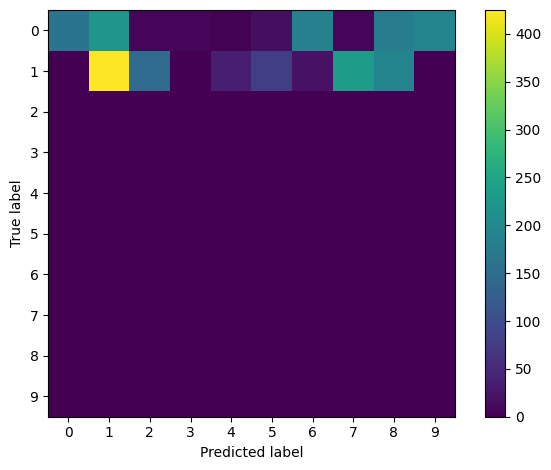

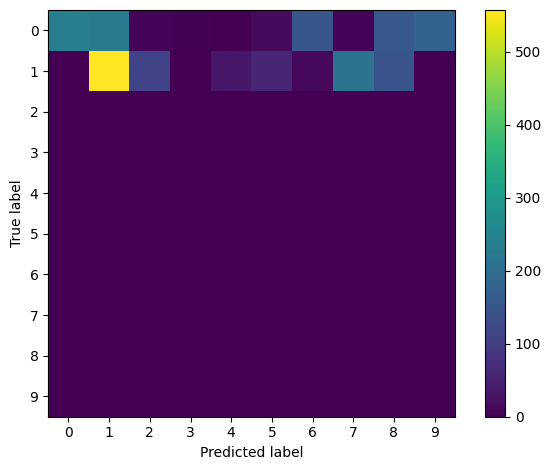

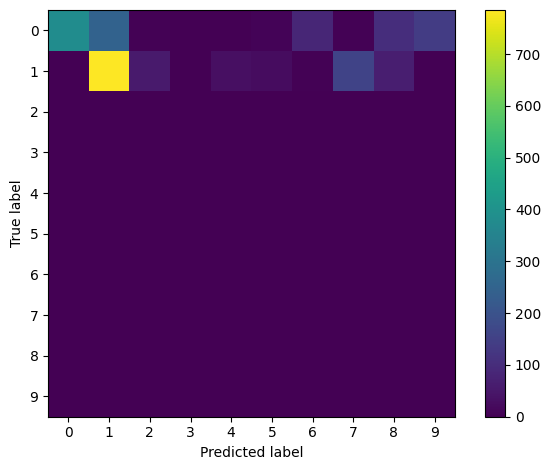

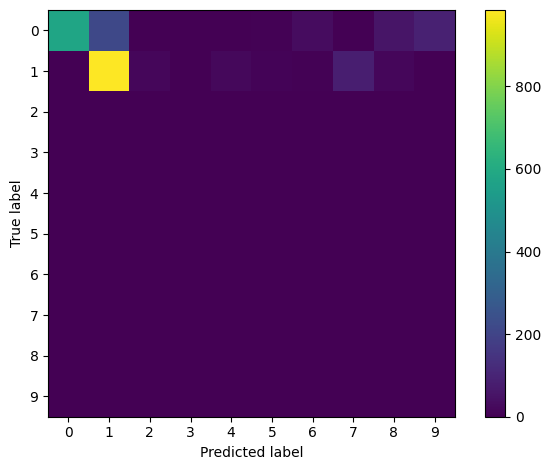

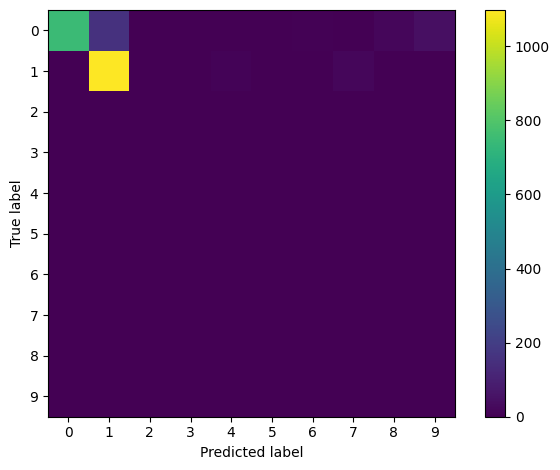

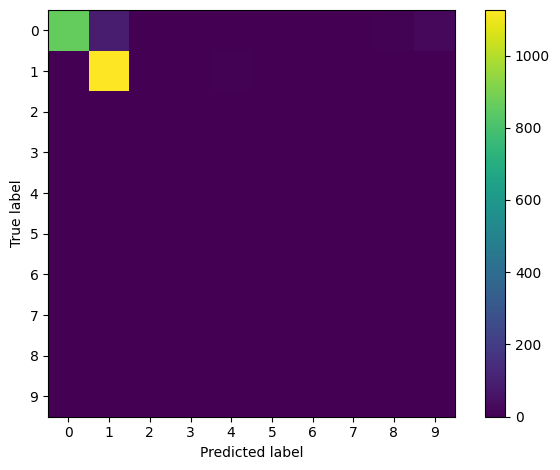

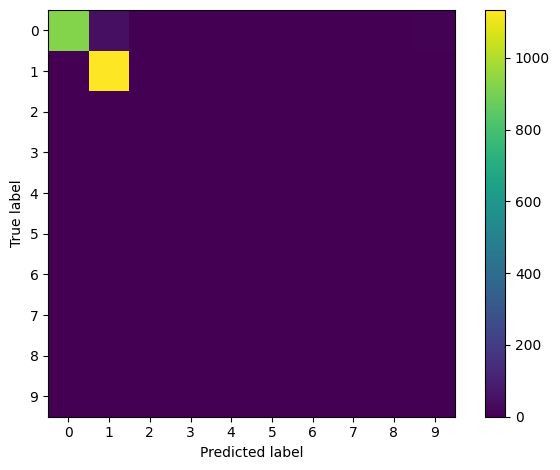

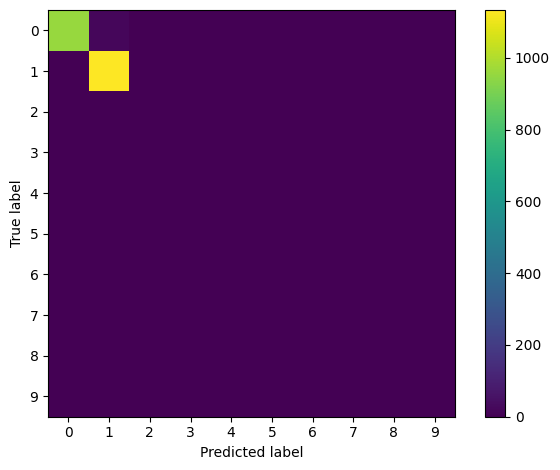

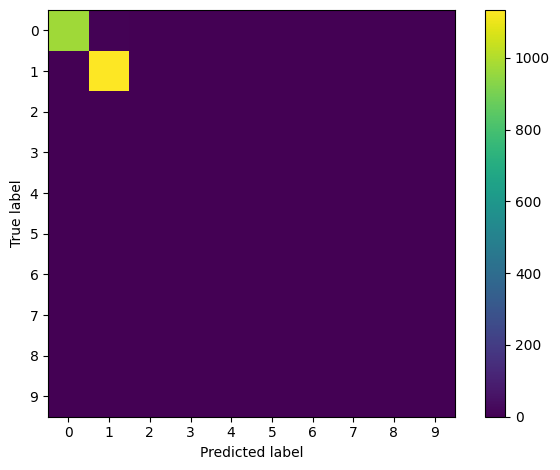

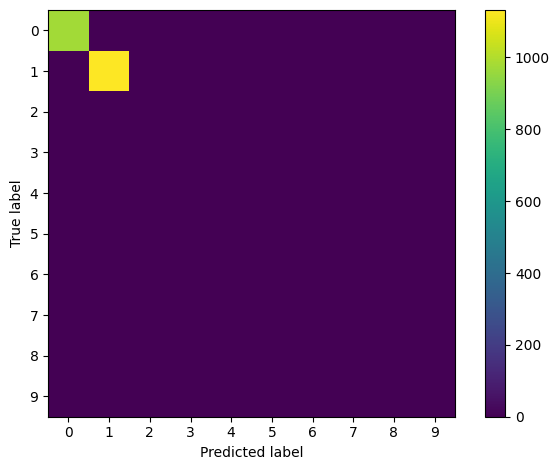

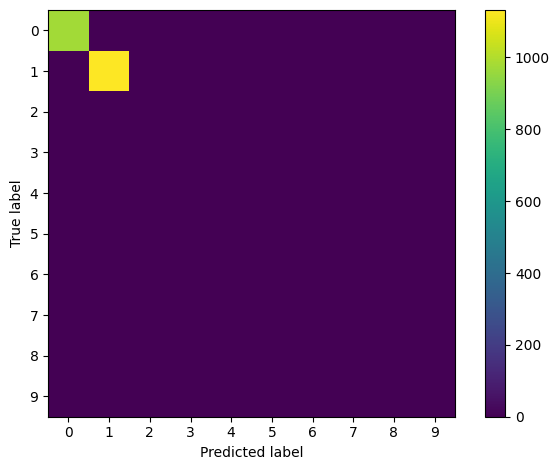

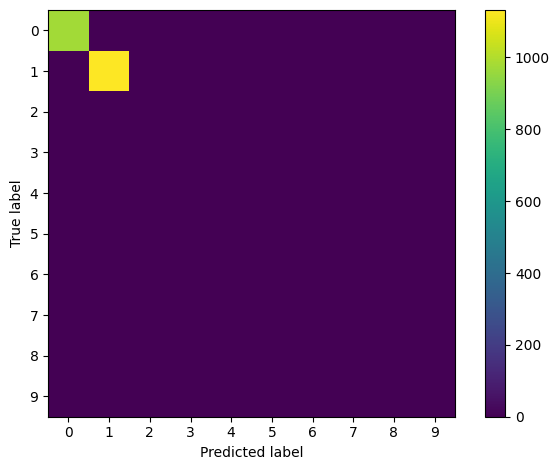

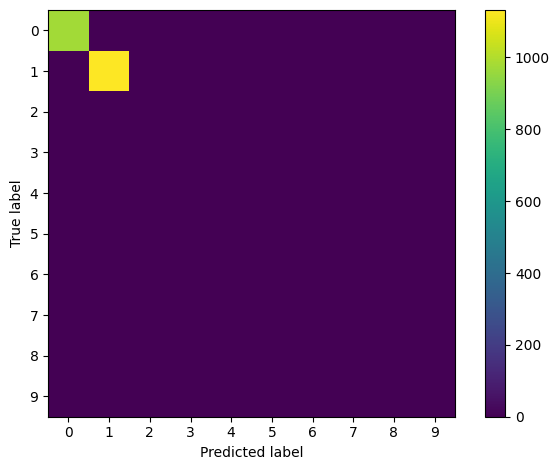

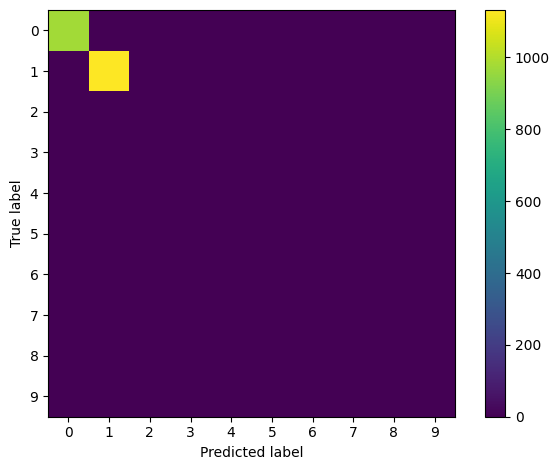

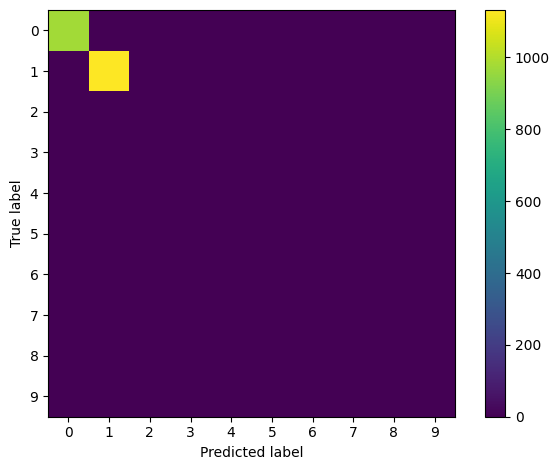

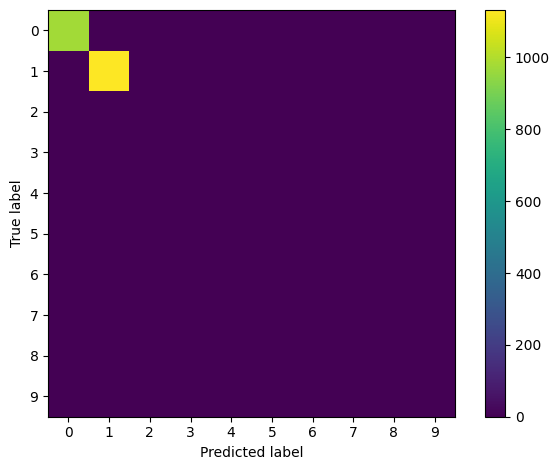

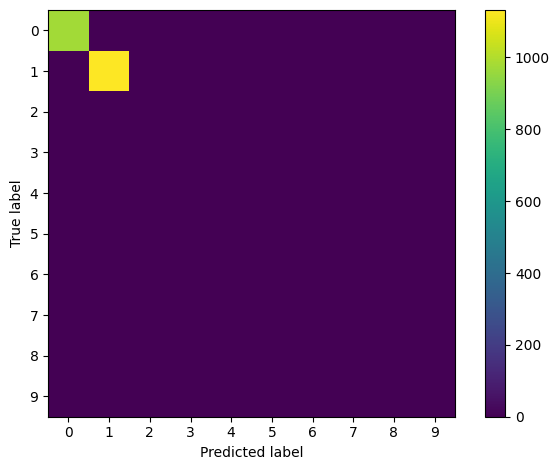

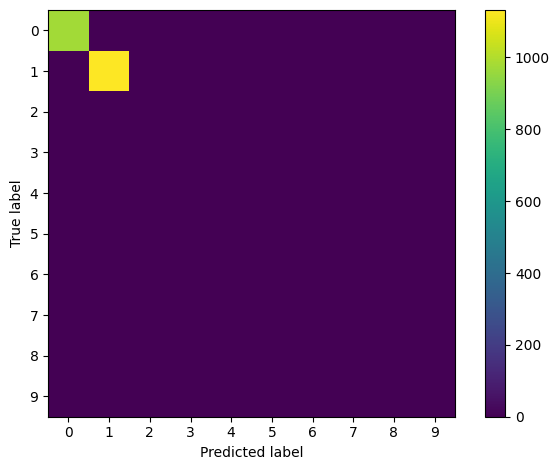

In [32]:
episode = 0
with mlflow.start_run():
    mlflow.log_param("Labels", train_stream[0].classes_in_this_experience)
    hist = cl_strategy.train(train_stream[0], eval_streams=[test_stream[0]])
    eval = cl_strategy.eval(test_stream[0])
    mlflow.log_metrics({"train_"+metric_map.get(key.split('/')[0]):value for key, value in hist.items() if metric_map.get(key.split('/')[0])})
    mlflow.log_metrics({"eval_"+metric_map.get(key.split('/')[0]):value for key, value in eval.items() if metric_map.get(key.split('/')[0])})
    

In [38]:
mlflow.log_artifact("gdumb")

In [36]:
save_checkpoint(cl_strategy, "./gdumb")

In [42]:
strategy, initial_exp = maybe_load_checkpoint(cl_strategy, "./gdumb")

In [43]:
initial_exp

0